In [1]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import io
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm 
from skimage.metrics import structural_similarity as ssim
import lpips 
from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import save_image
import random

## Preprocessing

In [2]:
dataset_path1 = '/home/tdiykanba2/codes/RRDB_SE_CHECKPOINTS_random_invert/augmented_images'
train_path = f'{dataset_path1}/train'
val_path = f'{dataset_path1}/val'
test_path = f'{dataset_path1}/test'

In [3]:
class CleanDataset(Dataset):
    def __init__(self, root_dir, target_transform=None):
        self.root_dir = root_dir
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.target_transform:
            low_img = self.target_transform(low_img)
            high_img = self.target_transform(high_img)
            
            
        low_filename = os.path.basename(low_img_path)
        high_filename = os.path.basename(high_img_path)
        
        return low_img, high_img, low_filename, high_filename

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = CleanDataset(
    root_dir=train_path, 
    target_transform = target_transform
)

val_dataset = CleanDataset(
    root_dir=val_path,
    target_transform = target_transform
)

test_dataset = CleanDataset(root_dir=test_path, target_transform = target_transform)

In [4]:
batch_size = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [5]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Low resolution file name: ['206.png', '257.png', '526.png', '680.png', '48.png', '265.png', '609.png', '185.png']
High resolution file name: ['206.png', '257.png', '526.png', '680.png', '48.png', '265.png', '609.png', '185.png']


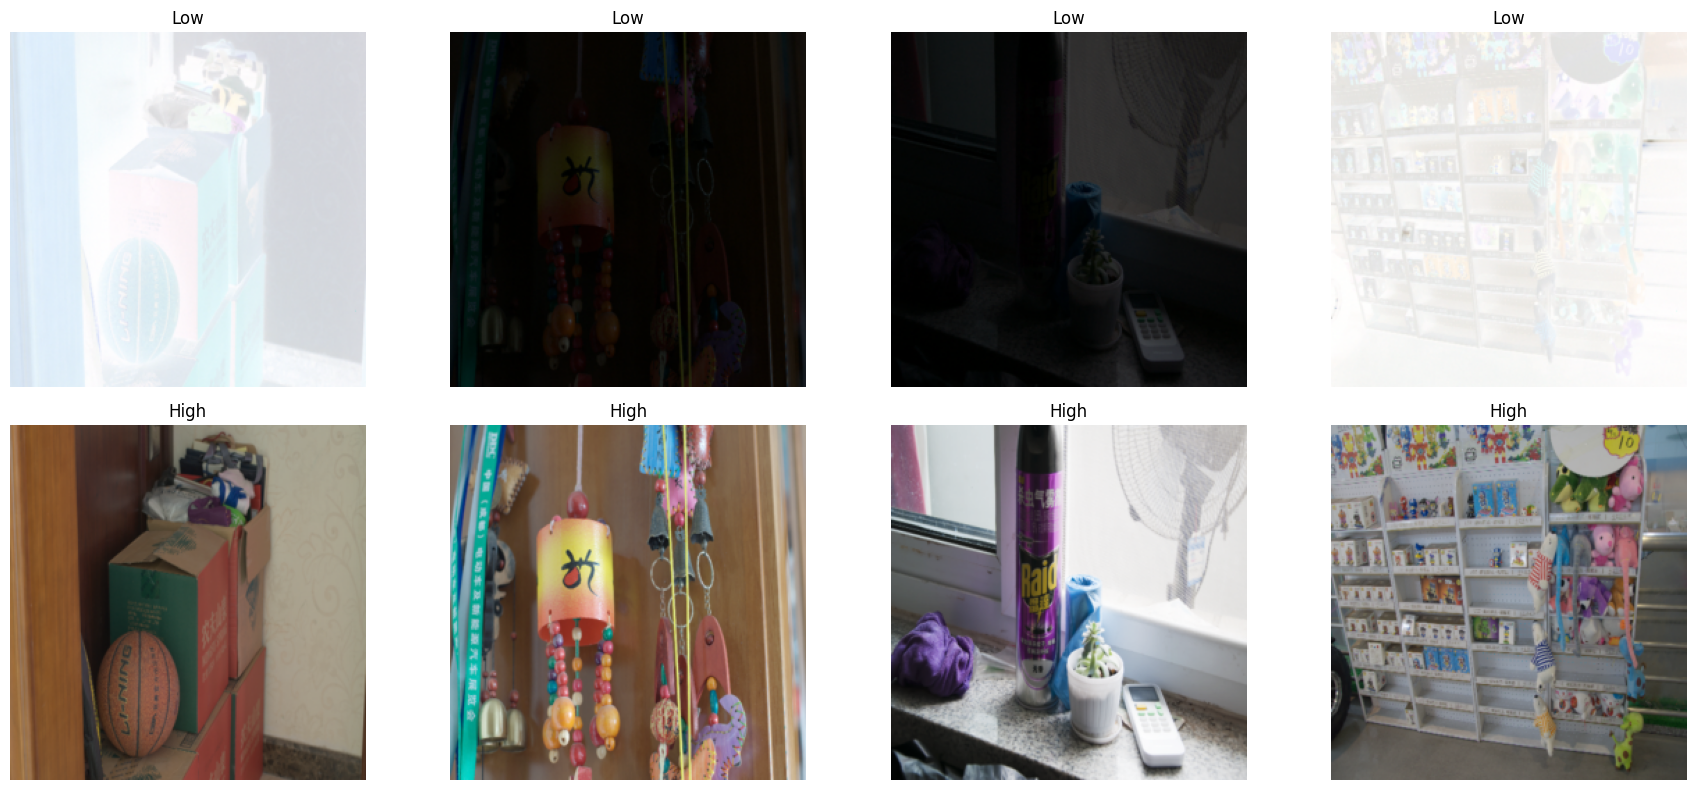

In [6]:
low, high, low_filename, high_filename = next(iter(train_loader))
print("Low resolution file name:", low_filename)
print("High resolution file name:", high_filename)
show_true_images(low, high)

## Model Architecture

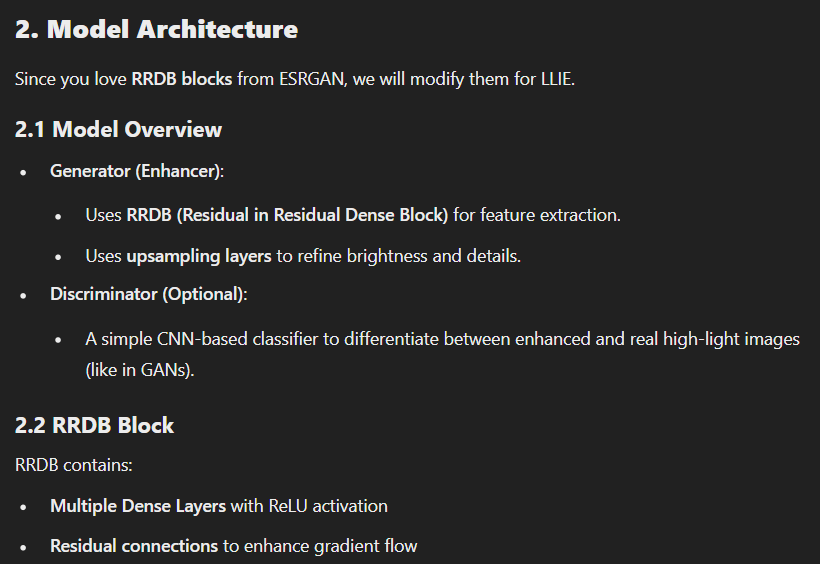

In [7]:
## RRDB blocks architecture derived from the paper ESRGAN..

class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels=64, growth_rate=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_rate, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        out1 = torch.relu(self.conv1(x))
        out2 = torch.relu(self.conv2(torch.cat([x, out1], dim=1)))
        out3 = self.conv3(torch.cat([x, out1, out2], dim=1))
        return x + out3

class RRDB(nn.Module):
    def __init__(self, in_channels=64, beta=0.2):  
        super(RRDB, self).__init__()
        self.rdb1 = ResidualDenseBlock(in_channels)
        self.rdb2 = ResidualDenseBlock(in_channels)
        self.rdb3 = ResidualDenseBlock(in_channels)
        self.beta = beta  # Scaling factor for residual

    def forward(self, x):
        residual = self.rdb3(self.rdb2(self.rdb1(x)))
        return x + self.beta * residual  # Scaled residual for stability

In [8]:
class Generator(nn.Module):
    def __init__(self, num_rrdb=6):
        super(Generator, self).__init__()

        # Initial feature extraction
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # RRDB Blocks
        self.rrdb_blocks = nn.Sequential(*[RRDB(64) for _ in range(num_rrdb)])

        # Global Residual Path (helps learn overall brightness correction)
        self.global_residual = nn.Conv2d(3, 3, kernel_size=3, padding=1)

        # Final convolution layers for reconstruction
        self.final_conv = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        initial_features = self.initial_conv(x)
        enhanced_features = self.rrdb_blocks(initial_features)
        reconstructed = self.final_conv(enhanced_features)
        
        # Adding the global residual path
        output = reconstructed + self.global_residual(x)
        
        return torch.sigmoid(output)  # Normalize output to [0,1]

In [9]:
'''  Use a Discriminator (GAN Approach)
        This makes the enhanced image look more realistic by forcing the Generator to fool a Discriminator.
        USES PatchGANDiscriminator idea as the Discriminator'''

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, num_filters=64, num_layers=3):
        super(PatchGANDiscriminator, self).__init__()
        
        # Initial convolutional layer
        layers = [
            nn.Conv2d(in_channels, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Intermediate convolutional layers
        for i in range(1, num_layers):
            layers += [
                nn.Conv2d(num_filters * (2 ** (i - 1)), num_filters * (2 ** i), kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(num_filters * (2 ** i)),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        
        # Final convolutional layer
        layers += [
            nn.Conv2d(num_filters * (2 ** (num_layers - 1)), 1, kernel_size=4, stride=1, padding=1)
        ]
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # Output shape: [batch_size, 1, H, W]

In [10]:
## Loss Functions

# L1 Loss (Pixel-Level Difference)
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)

# Perceptual Loss using VGG-19 Features
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16]  # Use first few layers
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG model
        self.vgg = vgg.eval()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_features = self.vgg(x)
        y_features = self.vgg(y)
        return self.criterion(x_features, y_features)

In [11]:
## Common evaluating Metrics
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

# Initialize models and losses
generator = Generator().to(device)
discriminator = PatchGANDiscriminator().to(device)
opt_g = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_d = optim.Adam(discriminator.parameters(), lr = 4e-4, betas=(0.5, 0.999))

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tdiykanba2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated

In [12]:
def validate(generator, val_loader, epoch):
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0, 'val_loss': 0}

    with torch.no_grad():
        for low, high, *_ in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Validation loss (L1 + perceptual)
            loss = (10 * F.l1_loss(fake, high) + 0.1 * criterion_perceptual(fake, high)).item()
            
            # Update metrics
            val_metrics['val_loss'] += loss
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    for k in val_metrics:
        val_metrics[k] /= len(val_loader)
    return val_metrics

Source: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

In [13]:
def compute_gradient_penalty(disc, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = disc(interpolates)
    fake = torch.ones_like(d_interpolates)
    
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [14]:
def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_CHECKPOINTS_random_invert"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0
    best_psnr=0
    best_lpips=100

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high, *_ in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)
            
            gp = compute_gradient_penalty(discriminator, high.data, fake.data)
            d_loss = (real_loss + fake_loss) / 2+ 10*gp
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 10
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['lpips'] < best_lpips) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips_ssim.pth'))
            print(f"🔥 New best model (LPIPS: {val_metrics['lpips']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['ssim'] > best_ssim):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_ssim.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | SSIM: {val_metrics['ssim']:.4f}) saved!")

        if (val_metrics['psnr'] > best_psnr) and (val_metrics['lpips'] < best_lpips):
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr_lpips.pth'))
            print(f"🔥 New best model (PSNR: {val_metrics['psnr']:.4f} | LPIPS: {val_metrics['lpips']:.4f}) saved!")
                
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_ssim.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")
                    
        if val_metrics['psnr'] > best_psnr:
            best_psnr = val_metrics['psnr']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_psnr.pth'))
            print(f"🔥 New best model (PSNR: {best_psnr:.4f}) saved!")

        if val_metrics['lpips'] < best_lpips:
            best_lpips = val_metrics['lpips']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_lpips.pth'))
            print(f"🔥 New best model (LPIPS: {best_lpips:.4f}) saved!")

        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [15]:
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|█| 49/49 [00:26<00:00,  1.84it/s, D_loss=69.678, G_loss=1.720,
                                                                                


Validation @ Epoch 1:
PSNR: 15.30 dB | SSIM: 0.6204 | LPIPS: 0.5043
🔥 New best model (PSNR: 15.3021 | LPIPS: 0.5043 | SSIM: 0.6204) saved!
🔥 New best model (LPIPS: 0.5043 | SSIM: 0.6204) saved!
🔥 New best model (PSNR: 15.3021 | SSIM: 0.6204) saved!
🔥 New best model (PSNR: 15.3021 | LPIPS: 0.5043) saved!
🔥 New best model (SSIM: 0.6204) saved!
🔥 New best model (PSNR: 15.3021) saved!
🔥 New best model (LPIPS: 0.5043) saved!


Epoch 2/200: 100%|█| 49/49 [00:26<00:00,  1.85it/s, D_loss=10.219, G_loss=2.127,
                                                                                


Validation @ Epoch 2:
PSNR: 15.47 dB | SSIM: 0.6471 | LPIPS: 0.4427
🔥 New best model (PSNR: 15.4655 | LPIPS: 0.4427 | SSIM: 0.6471) saved!
🔥 New best model (LPIPS: 0.4427 | SSIM: 0.6471) saved!
🔥 New best model (PSNR: 15.4655 | SSIM: 0.6471) saved!
🔥 New best model (PSNR: 15.4655 | LPIPS: 0.4427) saved!
🔥 New best model (SSIM: 0.6471) saved!
🔥 New best model (PSNR: 15.4655) saved!
🔥 New best model (LPIPS: 0.4427) saved!


Epoch 3/200: 100%|█| 49/49 [00:26<00:00,  1.82it/s, D_loss=14.891, G_loss=2.215,
                                                                                


Validation @ Epoch 3:
PSNR: 15.65 dB | SSIM: 0.6586 | LPIPS: 0.4197
🔥 New best model (PSNR: 15.6503 | LPIPS: 0.4197 | SSIM: 0.6586) saved!
🔥 New best model (LPIPS: 0.4197 | SSIM: 0.6586) saved!
🔥 New best model (PSNR: 15.6503 | SSIM: 0.6586) saved!
🔥 New best model (PSNR: 15.6503 | LPIPS: 0.4197) saved!
🔥 New best model (SSIM: 0.6586) saved!
🔥 New best model (PSNR: 15.6503) saved!
🔥 New best model (LPIPS: 0.4197) saved!


Epoch 4/200: 100%|█| 49/49 [00:27<00:00,  1.80it/s, D_loss=0.969, G_loss=2.133, 
                                                                                


Validation @ Epoch 4:
PSNR: 14.71 dB | SSIM: 0.6735 | LPIPS: 0.3786
🔥 New best model (LPIPS: 0.3786 | SSIM: 0.6735) saved!
🔥 New best model (SSIM: 0.6735) saved!
🔥 New best model (LPIPS: 0.3786) saved!


Epoch 5/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=11.186, G_loss=2.220,
                                                                                


Validation @ Epoch 5:
PSNR: 15.60 dB | SSIM: 0.6977 | LPIPS: 0.3684
🔥 New best model (LPIPS: 0.3684 | SSIM: 0.6977) saved!
🔥 New best model (SSIM: 0.6977) saved!
🔥 New best model (LPIPS: 0.3684) saved!


Epoch 6/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.236, G_loss=2.125, 
                                                                                


Validation @ Epoch 6:
PSNR: 15.30 dB | SSIM: 0.7101 | LPIPS: 0.3447
🔥 New best model (LPIPS: 0.3447 | SSIM: 0.7101) saved!
🔥 New best model (SSIM: 0.7101) saved!
🔥 New best model (LPIPS: 0.3447) saved!


Epoch 7/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.524, G_loss=1.701, 
                                                                                


Validation @ Epoch 7:
PSNR: 15.74 dB | SSIM: 0.7360 | LPIPS: 0.3483
🔥 New best model (PSNR: 15.7399 | SSIM: 0.7360) saved!
🔥 New best model (SSIM: 0.7360) saved!
🔥 New best model (PSNR: 15.7399) saved!


Epoch 8/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=16.941, G_loss=1.944,
                                                                                


Validation @ Epoch 8:
PSNR: 16.01 dB | SSIM: 0.7470 | LPIPS: 0.3144
🔥 New best model (PSNR: 16.0056 | LPIPS: 0.3144 | SSIM: 0.7470) saved!
🔥 New best model (LPIPS: 0.3144 | SSIM: 0.7470) saved!
🔥 New best model (PSNR: 16.0056 | SSIM: 0.7470) saved!
🔥 New best model (PSNR: 16.0056 | LPIPS: 0.3144) saved!
🔥 New best model (SSIM: 0.7470) saved!
🔥 New best model (PSNR: 16.0056) saved!
🔥 New best model (LPIPS: 0.3144) saved!


Epoch 9/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.915, G_loss=1.554, 
                                                                                


Validation @ Epoch 9:
PSNR: 16.50 dB | SSIM: 0.7549 | LPIPS: 0.3196
🔥 New best model (PSNR: 16.5000 | SSIM: 0.7549) saved!
🔥 New best model (SSIM: 0.7549) saved!
🔥 New best model (PSNR: 16.5000) saved!


Epoch 10/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.852, G_loss=1.692,
                                                                                


Validation @ Epoch 10:
PSNR: 16.65 dB | SSIM: 0.7621 | LPIPS: 0.3202
🔥 New best model (PSNR: 16.6454 | SSIM: 0.7621) saved!
🔥 New best model (SSIM: 0.7621) saved!
🔥 New best model (PSNR: 16.6454) saved!


Epoch 11/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.880, G_loss=2.002,
                                                                                


Validation @ Epoch 11:
PSNR: 15.11 dB | SSIM: 0.7139 | LPIPS: 0.3295


Epoch 12/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.300, G_loss=1.761,
                                                                                


Validation @ Epoch 12:
PSNR: 16.80 dB | SSIM: 0.7650 | LPIPS: 0.3033
🔥 New best model (PSNR: 16.8021 | LPIPS: 0.3033 | SSIM: 0.7650) saved!
🔥 New best model (LPIPS: 0.3033 | SSIM: 0.7650) saved!
🔥 New best model (PSNR: 16.8021 | SSIM: 0.7650) saved!
🔥 New best model (PSNR: 16.8021 | LPIPS: 0.3033) saved!
🔥 New best model (SSIM: 0.7650) saved!
🔥 New best model (PSNR: 16.8021) saved!
🔥 New best model (LPIPS: 0.3033) saved!


Epoch 13/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.299, G_loss=2.067,
                                                                                


Validation @ Epoch 13:
PSNR: 15.48 dB | SSIM: 0.7519 | LPIPS: 0.3423


Epoch 14/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.243, G_loss=2.263,
                                                                                


Validation @ Epoch 14:
PSNR: 16.53 dB | SSIM: 0.7735 | LPIPS: 0.2980
🔥 New best model (LPIPS: 0.2980 | SSIM: 0.7735) saved!
🔥 New best model (SSIM: 0.7735) saved!
🔥 New best model (LPIPS: 0.2980) saved!


Epoch 15/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.932, G_loss=2.221,
                                                                                


Validation @ Epoch 15:
PSNR: 16.61 dB | SSIM: 0.7695 | LPIPS: 0.2952
🔥 New best model (LPIPS: 0.2952) saved!


Epoch 16/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.102, G_loss=1.781,
                                                                                


Validation @ Epoch 16:
PSNR: 17.01 dB | SSIM: 0.7834 | LPIPS: 0.2837
🔥 New best model (PSNR: 17.0087 | LPIPS: 0.2837 | SSIM: 0.7834) saved!
🔥 New best model (LPIPS: 0.2837 | SSIM: 0.7834) saved!
🔥 New best model (PSNR: 17.0087 | SSIM: 0.7834) saved!
🔥 New best model (PSNR: 17.0087 | LPIPS: 0.2837) saved!
🔥 New best model (SSIM: 0.7834) saved!
🔥 New best model (PSNR: 17.0087) saved!
🔥 New best model (LPIPS: 0.2837) saved!


Epoch 17/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=7.288, G_loss=1.740,
                                                                                


Validation @ Epoch 17:
PSNR: 16.63 dB | SSIM: 0.7795 | LPIPS: 0.2773
🔥 New best model (LPIPS: 0.2773) saved!


Epoch 18/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.147, G_loss=2.506,
                                                                                


Validation @ Epoch 18:
PSNR: 16.45 dB | SSIM: 0.7791 | LPIPS: 0.2827


Epoch 19/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.712, G_loss=1.819,
                                                                                


Validation @ Epoch 19:
PSNR: 16.47 dB | SSIM: 0.7600 | LPIPS: 0.2838


Epoch 20/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.471, G_loss=2.181,
                                                                                


Validation @ Epoch 20:
PSNR: 16.88 dB | SSIM: 0.7873 | LPIPS: 0.2745
🔥 New best model (LPIPS: 0.2745 | SSIM: 0.7873) saved!
🔥 New best model (SSIM: 0.7873) saved!
🔥 New best model (LPIPS: 0.2745) saved!


Epoch 21/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.964, G_loss=2.207,
                                                                                


Validation @ Epoch 21:
PSNR: 16.66 dB | SSIM: 0.7885 | LPIPS: 0.2673
🔥 New best model (LPIPS: 0.2673 | SSIM: 0.7885) saved!
🔥 New best model (SSIM: 0.7885) saved!
🔥 New best model (LPIPS: 0.2673) saved!


Epoch 22/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.560, G_loss=2.048,
                                                                                


Validation @ Epoch 22:
PSNR: 16.57 dB | SSIM: 0.7901 | LPIPS: 0.2748
🔥 New best model (SSIM: 0.7901) saved!


Epoch 23/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.501, G_loss=2.396,
                                                                                


Validation @ Epoch 23:
PSNR: 17.12 dB | SSIM: 0.8000 | LPIPS: 0.2614
🔥 New best model (PSNR: 17.1175 | LPIPS: 0.2614 | SSIM: 0.8000) saved!
🔥 New best model (LPIPS: 0.2614 | SSIM: 0.8000) saved!
🔥 New best model (PSNR: 17.1175 | SSIM: 0.8000) saved!
🔥 New best model (PSNR: 17.1175 | LPIPS: 0.2614) saved!
🔥 New best model (SSIM: 0.8000) saved!
🔥 New best model (PSNR: 17.1175) saved!
🔥 New best model (LPIPS: 0.2614) saved!


Epoch 24/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.151, G_loss=1.562,
                                                                                


Validation @ Epoch 24:
PSNR: 17.09 dB | SSIM: 0.8005 | LPIPS: 0.2659
🔥 New best model (SSIM: 0.8005) saved!


Epoch 25/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.077, G_loss=2.612,
                                                                                


Validation @ Epoch 25:
PSNR: 16.81 dB | SSIM: 0.8024 | LPIPS: 0.2571
🔥 New best model (LPIPS: 0.2571 | SSIM: 0.8024) saved!
🔥 New best model (SSIM: 0.8024) saved!
🔥 New best model (LPIPS: 0.2571) saved!


Epoch 26/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.203, G_loss=2.457,
                                                                                


Validation @ Epoch 26:
PSNR: 16.99 dB | SSIM: 0.8067 | LPIPS: 0.2613
🔥 New best model (SSIM: 0.8067) saved!


Epoch 27/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.908, G_loss=1.980,
                                                                                


Validation @ Epoch 27:
PSNR: 16.74 dB | SSIM: 0.7972 | LPIPS: 0.2616


Epoch 28/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=4.730, G_loss=1.509,
                                                                                


Validation @ Epoch 28:
PSNR: 16.64 dB | SSIM: 0.7963 | LPIPS: 0.2834


Epoch 29/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.915, G_loss=1.943,
                                                                                


Validation @ Epoch 29:
PSNR: 17.34 dB | SSIM: 0.8104 | LPIPS: 0.2452
🔥 New best model (PSNR: 17.3393 | LPIPS: 0.2452 | SSIM: 0.8104) saved!
🔥 New best model (LPIPS: 0.2452 | SSIM: 0.8104) saved!
🔥 New best model (PSNR: 17.3393 | SSIM: 0.8104) saved!
🔥 New best model (PSNR: 17.3393 | LPIPS: 0.2452) saved!
🔥 New best model (SSIM: 0.8104) saved!
🔥 New best model (PSNR: 17.3393) saved!
🔥 New best model (LPIPS: 0.2452) saved!


Epoch 30/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.827, G_loss=1.934,
                                                                                


Validation @ Epoch 30:
PSNR: 16.05 dB | SSIM: 0.7803 | LPIPS: 0.2750


Epoch 31/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.924, G_loss=1.580,
                                                                                


Validation @ Epoch 31:
PSNR: 17.07 dB | SSIM: 0.8133 | LPIPS: 0.2475
🔥 New best model (SSIM: 0.8133) saved!


Epoch 32/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.793, G_loss=1.686,
                                                                                


Validation @ Epoch 32:
PSNR: 16.87 dB | SSIM: 0.8100 | LPIPS: 0.2462


Epoch 33/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=3.354, G_loss=2.115,
                                                                                


Validation @ Epoch 33:
PSNR: 16.72 dB | SSIM: 0.7987 | LPIPS: 0.2627


Epoch 34/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.899, G_loss=1.806,
                                                                                


Validation @ Epoch 34:
PSNR: 17.11 dB | SSIM: 0.8100 | LPIPS: 0.2468


Epoch 35/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.881, G_loss=2.174,
                                                                                


Validation @ Epoch 35:
PSNR: 16.94 dB | SSIM: 0.8060 | LPIPS: 0.2600


Epoch 36/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.879, G_loss=1.716,
                                                                                


Validation @ Epoch 36:
PSNR: 17.23 dB | SSIM: 0.8117 | LPIPS: 0.2474


Epoch 37/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=2.072, G_loss=2.238,
                                                                                


Validation @ Epoch 37:
PSNR: 16.82 dB | SSIM: 0.8085 | LPIPS: 0.2435
🔥 New best model (LPIPS: 0.2435) saved!


Epoch 38/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.812, G_loss=1.850,
                                                                                


Validation @ Epoch 38:
PSNR: 17.29 dB | SSIM: 0.8022 | LPIPS: 0.2627


Epoch 39/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.724, G_loss=2.040,
                                                                                


Validation @ Epoch 39:
PSNR: 16.63 dB | SSIM: 0.8055 | LPIPS: 0.2489


Epoch 40/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.756, G_loss=1.835,
                                                                                


Validation @ Epoch 40:
PSNR: 17.16 dB | SSIM: 0.8204 | LPIPS: 0.2430
🔥 New best model (LPIPS: 0.2430 | SSIM: 0.8204) saved!
🔥 New best model (SSIM: 0.8204) saved!
🔥 New best model (LPIPS: 0.2430) saved!


Epoch 41/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.080, G_loss=1.970,
                                                                                


Validation @ Epoch 41:
PSNR: 16.85 dB | SSIM: 0.7991 | LPIPS: 0.2596


Epoch 42/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.421, G_loss=1.842,
                                                                                


Validation @ Epoch 42:
PSNR: 16.56 dB | SSIM: 0.7903 | LPIPS: 0.2730


Epoch 43/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.913, G_loss=1.654,
                                                                                


Validation @ Epoch 43:
PSNR: 16.92 dB | SSIM: 0.8140 | LPIPS: 0.2478


Epoch 44/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.809, G_loss=2.140,
                                                                                


Validation @ Epoch 44:
PSNR: 17.17 dB | SSIM: 0.8178 | LPIPS: 0.2476


Epoch 45/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.440, G_loss=1.856,
                                                                                


Validation @ Epoch 45:
PSNR: 16.95 dB | SSIM: 0.8122 | LPIPS: 0.2437


Epoch 46/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.826, G_loss=1.860,
                                                                                


Validation @ Epoch 46:
PSNR: 17.17 dB | SSIM: 0.8239 | LPIPS: 0.2293
🔥 New best model (LPIPS: 0.2293 | SSIM: 0.8239) saved!
🔥 New best model (SSIM: 0.8239) saved!
🔥 New best model (LPIPS: 0.2293) saved!


Epoch 47/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.788, G_loss=2.395,
                                                                                


Validation @ Epoch 47:
PSNR: 17.05 dB | SSIM: 0.8050 | LPIPS: 0.2599


Epoch 48/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.739, G_loss=1.532,
                                                                                


Validation @ Epoch 48:
PSNR: 17.32 dB | SSIM: 0.8295 | LPIPS: 0.2256
🔥 New best model (LPIPS: 0.2256 | SSIM: 0.8295) saved!
🔥 New best model (SSIM: 0.8295) saved!
🔥 New best model (LPIPS: 0.2256) saved!


Epoch 49/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.728, G_loss=1.916,
                                                                                


Validation @ Epoch 49:
PSNR: 16.90 dB | SSIM: 0.8102 | LPIPS: 0.2438


Epoch 50/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.726, G_loss=2.054,
                                                                                


Validation @ Epoch 50:
PSNR: 17.18 dB | SSIM: 0.8245 | LPIPS: 0.2380


Epoch 51/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=7.744, G_loss=1.982,
                                                                                


Validation @ Epoch 51:
PSNR: 17.30 dB | SSIM: 0.8284 | LPIPS: 0.2255
🔥 New best model (LPIPS: 0.2255) saved!


Epoch 52/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.801, G_loss=2.151,
                                                                                


Validation @ Epoch 52:
PSNR: 17.19 dB | SSIM: 0.8173 | LPIPS: 0.2373


Epoch 53/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.757, G_loss=1.746,
                                                                                


Validation @ Epoch 53:
PSNR: 17.41 dB | SSIM: 0.8220 | LPIPS: 0.2336
🔥 New best model (PSNR: 17.4079) saved!


Epoch 54/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.958, G_loss=1.475,
                                                                                


Validation @ Epoch 54:
PSNR: 16.86 dB | SSIM: 0.8185 | LPIPS: 0.2268


Epoch 55/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.784, G_loss=1.527,
                                                                                


Validation @ Epoch 55:
PSNR: 17.26 dB | SSIM: 0.8250 | LPIPS: 0.2516


Epoch 56/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.775, G_loss=1.680,
                                                                                


Validation @ Epoch 56:
PSNR: 17.22 dB | SSIM: 0.8217 | LPIPS: 0.2383


Epoch 57/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.733, G_loss=2.460,
                                                                                


Validation @ Epoch 57:
PSNR: 16.66 dB | SSIM: 0.8128 | LPIPS: 0.2483


Epoch 58/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.774, G_loss=1.509,
                                                                                


Validation @ Epoch 58:
PSNR: 17.32 dB | SSIM: 0.8226 | LPIPS: 0.2453


Epoch 59/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.722, G_loss=2.153,
                                                                                


Validation @ Epoch 59:
PSNR: 16.94 dB | SSIM: 0.8187 | LPIPS: 0.2407


Epoch 60/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.815, G_loss=1.767,
                                                                                


Validation @ Epoch 60:
PSNR: 17.26 dB | SSIM: 0.8167 | LPIPS: 0.2390


Epoch 61/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.901, G_loss=2.222,
                                                                                


Validation @ Epoch 61:
PSNR: 16.62 dB | SSIM: 0.8059 | LPIPS: 0.2533


Epoch 62/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.753, G_loss=2.577,
                                                                                


Validation @ Epoch 62:
PSNR: 16.39 dB | SSIM: 0.8174 | LPIPS: 0.2363


Epoch 63/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.938, G_loss=2.933,
                                                                                


Validation @ Epoch 63:
PSNR: 17.13 dB | SSIM: 0.8240 | LPIPS: 0.2302


Epoch 64/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.809, G_loss=1.636,
                                                                                


Validation @ Epoch 64:
PSNR: 16.88 dB | SSIM: 0.7968 | LPIPS: 0.2839


Epoch 65/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.767, G_loss=1.661,
                                                                                


Validation @ Epoch 65:
PSNR: 16.89 dB | SSIM: 0.8205 | LPIPS: 0.2363


Epoch 66/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.809, G_loss=2.409,
                                                                                


Validation @ Epoch 66:
PSNR: 16.91 dB | SSIM: 0.8207 | LPIPS: 0.2544


Epoch 67/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.762, G_loss=1.881,
                                                                                


Validation @ Epoch 67:
PSNR: 17.28 dB | SSIM: 0.8188 | LPIPS: 0.2500


Epoch 68/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.783, G_loss=1.878,
                                                                                


Validation @ Epoch 68:
PSNR: 17.13 dB | SSIM: 0.8291 | LPIPS: 0.2231
🔥 New best model (LPIPS: 0.2231) saved!


Epoch 69/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.742, G_loss=2.005,
                                                                                


Validation @ Epoch 69:
PSNR: 16.78 dB | SSIM: 0.8146 | LPIPS: 0.2997


Epoch 70/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.107, G_loss=1.785,
                                                                                


Validation @ Epoch 70:
PSNR: 17.51 dB | SSIM: 0.8325 | LPIPS: 0.2192
🔥 New best model (PSNR: 17.5076 | LPIPS: 0.2192 | SSIM: 0.8325) saved!
🔥 New best model (LPIPS: 0.2192 | SSIM: 0.8325) saved!
🔥 New best model (PSNR: 17.5076 | SSIM: 0.8325) saved!
🔥 New best model (PSNR: 17.5076 | LPIPS: 0.2192) saved!
🔥 New best model (SSIM: 0.8325) saved!
🔥 New best model (PSNR: 17.5076) saved!
🔥 New best model (LPIPS: 0.2192) saved!


Epoch 71/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.743, G_loss=1.600,
                                                                                


Validation @ Epoch 71:
PSNR: 17.57 dB | SSIM: 0.8369 | LPIPS: 0.2262
🔥 New best model (PSNR: 17.5698 | SSIM: 0.8369) saved!
🔥 New best model (SSIM: 0.8369) saved!
🔥 New best model (PSNR: 17.5698) saved!


Epoch 72/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.740, G_loss=1.594,
                                                                                


Validation @ Epoch 72:
PSNR: 17.54 dB | SSIM: 0.8368 | LPIPS: 0.2118
🔥 New best model (LPIPS: 0.2118) saved!


Epoch 73/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.698, G_loss=1.535,
                                                                                


Validation @ Epoch 73:
PSNR: 17.83 dB | SSIM: 0.8395 | LPIPS: 0.2118
🔥 New best model (PSNR: 17.8320 | SSIM: 0.8395) saved!
🔥 New best model (SSIM: 0.8395) saved!
🔥 New best model (PSNR: 17.8320) saved!


Epoch 74/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.704, G_loss=2.022,
                                                                                


Validation @ Epoch 74:
PSNR: 17.38 dB | SSIM: 0.8249 | LPIPS: 0.2579


Epoch 75/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.730, G_loss=1.391,
                                                                                


Validation @ Epoch 75:
PSNR: 17.13 dB | SSIM: 0.8302 | LPIPS: 0.2200


Epoch 76/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.756, G_loss=1.870,
                                                                                


Validation @ Epoch 76:
PSNR: 17.19 dB | SSIM: 0.8346 | LPIPS: 0.2206


Epoch 77/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.766, G_loss=1.799,
                                                                                


Validation @ Epoch 77:
PSNR: 17.48 dB | SSIM: 0.8390 | LPIPS: 0.2129


Epoch 78/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.727, G_loss=1.763,
                                                                                


Validation @ Epoch 78:
PSNR: 17.58 dB | SSIM: 0.8382 | LPIPS: 0.2080
🔥 New best model (LPIPS: 0.2080) saved!


Epoch 79/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.708, G_loss=2.113,
                                                                                


Validation @ Epoch 79:
PSNR: 17.61 dB | SSIM: 0.8369 | LPIPS: 0.2181


Epoch 80/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.826, G_loss=1.836,
                                                                                


Validation @ Epoch 80:
PSNR: 17.25 dB | SSIM: 0.8272 | LPIPS: 0.2294


Epoch 81/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.713, G_loss=1.822,
                                                                                


Validation @ Epoch 81:
PSNR: 17.63 dB | SSIM: 0.8350 | LPIPS: 0.2202


Epoch 82/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.753, G_loss=1.982,
                                                                                


Validation @ Epoch 82:
PSNR: 17.37 dB | SSIM: 0.8266 | LPIPS: 0.2534


Epoch 83/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.759, G_loss=2.133,
                                                                                


Validation @ Epoch 83:
PSNR: 17.21 dB | SSIM: 0.8292 | LPIPS: 0.2271


Epoch 84/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.756, G_loss=1.516,
                                                                                


Validation @ Epoch 84:
PSNR: 16.75 dB | SSIM: 0.8247 | LPIPS: 0.2426


Epoch 85/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.740, G_loss=1.726,
                                                                                


Validation @ Epoch 85:
PSNR: 17.81 dB | SSIM: 0.8438 | LPIPS: 0.2079
🔥 New best model (LPIPS: 0.2079 | SSIM: 0.8438) saved!
🔥 New best model (SSIM: 0.8438) saved!
🔥 New best model (LPIPS: 0.2079) saved!


Epoch 86/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.715, G_loss=2.030,
                                                                                


Validation @ Epoch 86:
PSNR: 17.20 dB | SSIM: 0.8244 | LPIPS: 0.2329


Epoch 87/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.707, G_loss=1.801,
                                                                                


Validation @ Epoch 87:
PSNR: 17.44 dB | SSIM: 0.8382 | LPIPS: 0.2102


Epoch 88/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.726, G_loss=1.737,
                                                                                


Validation @ Epoch 88:
PSNR: 17.19 dB | SSIM: 0.8250 | LPIPS: 0.2472


Epoch 89/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.726, G_loss=2.418,
                                                                                


Validation @ Epoch 89:
PSNR: 17.63 dB | SSIM: 0.8349 | LPIPS: 0.2189


Epoch 90/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.732, G_loss=1.538,
                                                                                


Validation @ Epoch 90:
PSNR: 17.91 dB | SSIM: 0.8441 | LPIPS: 0.2021
🔥 New best model (PSNR: 17.9138 | LPIPS: 0.2021 | SSIM: 0.8441) saved!
🔥 New best model (LPIPS: 0.2021 | SSIM: 0.8441) saved!
🔥 New best model (PSNR: 17.9138 | SSIM: 0.8441) saved!
🔥 New best model (PSNR: 17.9138 | LPIPS: 0.2021) saved!
🔥 New best model (SSIM: 0.8441) saved!
🔥 New best model (PSNR: 17.9138) saved!
🔥 New best model (LPIPS: 0.2021) saved!


Epoch 91/200: 100%|█| 49/49 [00:28<00:00,  1.75it/s, D_loss=0.719, G_loss=1.407,
                                                                                


Validation @ Epoch 91:
PSNR: 17.42 dB | SSIM: 0.8382 | LPIPS: 0.2103


Epoch 92/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.723, G_loss=1.997,
                                                                                


Validation @ Epoch 92:
PSNR: 17.34 dB | SSIM: 0.8285 | LPIPS: 0.2109


Epoch 93/200: 100%|█| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.797, G_loss=1.705,
                                                                                


Validation @ Epoch 93:
PSNR: 17.19 dB | SSIM: 0.8303 | LPIPS: 0.2414


Epoch 94/200: 100%|█| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.715, G_loss=2.191,
                                                                                


Validation @ Epoch 94:
PSNR: 17.72 dB | SSIM: 0.8374 | LPIPS: 0.2142


Epoch 95/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.723, G_loss=1.820,
                                                                                


Validation @ Epoch 95:
PSNR: 17.50 dB | SSIM: 0.8347 | LPIPS: 0.2127


Epoch 96/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.731, G_loss=2.143,
                                                                                


Validation @ Epoch 96:
PSNR: 17.93 dB | SSIM: 0.8456 | LPIPS: 0.2054
🔥 New best model (PSNR: 17.9310 | SSIM: 0.8456) saved!
🔥 New best model (SSIM: 0.8456) saved!
🔥 New best model (PSNR: 17.9310) saved!


Epoch 97/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.725, G_loss=3.149,
                                                                                


Validation @ Epoch 97:
PSNR: 17.34 dB | SSIM: 0.8364 | LPIPS: 0.2565


Epoch 98/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.769, G_loss=1.639,
                                                                                


Validation @ Epoch 98:
PSNR: 17.56 dB | SSIM: 0.8405 | LPIPS: 0.2169


Epoch 99/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.727, G_loss=1.659,
                                                                                


Validation @ Epoch 99:
PSNR: 17.72 dB | SSIM: 0.8342 | LPIPS: 0.2190


Epoch 100/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.730, G_loss=2.117
                                                                                


Validation @ Epoch 100:
PSNR: 17.59 dB | SSIM: 0.8353 | LPIPS: 0.2249


Epoch 101/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.737, G_loss=2.084
                                                                                


Validation @ Epoch 101:
PSNR: 17.46 dB | SSIM: 0.8348 | LPIPS: 0.2324


Epoch 102/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.699, G_loss=1.762
                                                                                


Validation @ Epoch 102:
PSNR: 17.73 dB | SSIM: 0.8377 | LPIPS: 0.2232


Epoch 103/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.715, G_loss=1.675
                                                                                


Validation @ Epoch 103:
PSNR: 18.00 dB | SSIM: 0.8421 | LPIPS: 0.2080
🔥 New best model (PSNR: 18.0017) saved!


Epoch 104/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.707, G_loss=1.406
                                                                                


Validation @ Epoch 104:
PSNR: 17.99 dB | SSIM: 0.8438 | LPIPS: 0.2037


Epoch 105/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.715, G_loss=1.486
                                                                                


Validation @ Epoch 105:
PSNR: 17.66 dB | SSIM: 0.8323 | LPIPS: 0.2272


Epoch 106/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.962, G_loss=1.454
                                                                                


Validation @ Epoch 106:
PSNR: 17.85 dB | SSIM: 0.8430 | LPIPS: 0.2100


Epoch 107/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.712, G_loss=1.632
                                                                                


Validation @ Epoch 107:
PSNR: 17.84 dB | SSIM: 0.8427 | LPIPS: 0.2150


Epoch 108/200: 100%|█| 49/49 [00:28<00:00,  1.75it/s, D_loss=1.290, G_loss=1.628
                                                                                


Validation @ Epoch 108:
PSNR: 18.02 dB | SSIM: 0.8452 | LPIPS: 0.2116
🔥 New best model (PSNR: 18.0170) saved!


Epoch 109/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.330, G_loss=1.536
                                                                                


Validation @ Epoch 109:
PSNR: 17.72 dB | SSIM: 0.8372 | LPIPS: 0.2225


Epoch 110/200: 100%|█| 49/49 [00:27<00:00,  1.75it/s, D_loss=1.001, G_loss=1.825
                                                                                


Validation @ Epoch 110:
PSNR: 17.94 dB | SSIM: 0.8438 | LPIPS: 0.2115


Epoch 111/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.204, G_loss=1.876
                                                                                


Validation @ Epoch 111:
PSNR: 17.80 dB | SSIM: 0.8415 | LPIPS: 0.2047


Epoch 112/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.139, G_loss=1.767
                                                                                


Validation @ Epoch 112:
PSNR: 17.87 dB | SSIM: 0.8450 | LPIPS: 0.2092


Epoch 113/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.871, G_loss=1.458
                                                                                


Validation @ Epoch 113:
PSNR: 17.82 dB | SSIM: 0.8368 | LPIPS: 0.2043


Epoch 114/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.053, G_loss=1.622
                                                                                


Validation @ Epoch 114:
PSNR: 17.82 dB | SSIM: 0.8417 | LPIPS: 0.2219


Epoch 115/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.221, G_loss=2.022
                                                                                


Validation @ Epoch 115:
PSNR: 17.42 dB | SSIM: 0.8327 | LPIPS: 0.2145


Epoch 116/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=2.304, G_loss=1.687
                                                                                


Validation @ Epoch 116:
PSNR: 17.92 dB | SSIM: 0.8408 | LPIPS: 0.2085


Epoch 117/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.194, G_loss=2.017
                                                                                


Validation @ Epoch 117:
PSNR: 17.88 dB | SSIM: 0.8357 | LPIPS: 0.2186


Epoch 118/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.717, G_loss=1.769
                                                                                


Validation @ Epoch 118:
PSNR: 18.14 dB | SSIM: 0.8448 | LPIPS: 0.2096
🔥 New best model (PSNR: 18.1354) saved!


Epoch 119/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.792, G_loss=1.609
                                                                                


Validation @ Epoch 119:
PSNR: 18.11 dB | SSIM: 0.8480 | LPIPS: 0.2099
🔥 New best model (SSIM: 0.8480) saved!


Epoch 120/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.752, G_loss=1.245
                                                                                


Validation @ Epoch 120:
PSNR: 17.43 dB | SSIM: 0.8436 | LPIPS: 0.2070


Epoch 121/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.884, G_loss=1.498
                                                                                


Validation @ Epoch 121:
PSNR: 17.80 dB | SSIM: 0.8420 | LPIPS: 0.2075


Epoch 122/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.033, G_loss=2.406
                                                                                


Validation @ Epoch 122:
PSNR: 17.78 dB | SSIM: 0.8450 | LPIPS: 0.2084


Epoch 123/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.724, G_loss=1.536
                                                                                


Validation @ Epoch 123:
PSNR: 17.91 dB | SSIM: 0.8447 | LPIPS: 0.2041


Epoch 124/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.808, G_loss=1.533
                                                                                


Validation @ Epoch 124:
PSNR: 18.42 dB | SSIM: 0.8509 | LPIPS: 0.2028
🔥 New best model (PSNR: 18.4219 | SSIM: 0.8509) saved!
🔥 New best model (SSIM: 0.8509) saved!
🔥 New best model (PSNR: 18.4219) saved!


Epoch 125/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.730, G_loss=1.764
                                                                                


Validation @ Epoch 125:
PSNR: 17.80 dB | SSIM: 0.8390 | LPIPS: 0.2107


Epoch 126/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.745, G_loss=1.849
                                                                                


Validation @ Epoch 126:
PSNR: 17.96 dB | SSIM: 0.8431 | LPIPS: 0.2195


Epoch 127/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.712, G_loss=1.985
                                                                                


Validation @ Epoch 127:
PSNR: 17.41 dB | SSIM: 0.8433 | LPIPS: 0.2110


Epoch 128/200: 100%|█| 49/49 [00:27<00:00,  1.76it/s, D_loss=0.735, G_loss=1.392
                                                                                


Validation @ Epoch 128:
PSNR: 18.09 dB | SSIM: 0.8453 | LPIPS: 0.2087


Epoch 129/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.803, G_loss=1.487
                                                                                


Validation @ Epoch 129:
PSNR: 18.22 dB | SSIM: 0.8511 | LPIPS: 0.2064
🔥 New best model (SSIM: 0.8511) saved!


Epoch 130/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.896, G_loss=1.559
                                                                                


Validation @ Epoch 130:
PSNR: 18.15 dB | SSIM: 0.8503 | LPIPS: 0.2012
🔥 New best model (LPIPS: 0.2012) saved!


Epoch 131/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.711, G_loss=1.326
                                                                                


Validation @ Epoch 131:
PSNR: 17.87 dB | SSIM: 0.8421 | LPIPS: 0.2137


Epoch 132/200: 100%|█| 49/49 [00:28<00:00,  1.74it/s, D_loss=0.771, G_loss=1.772
                                                                                


Validation @ Epoch 132:
PSNR: 18.24 dB | SSIM: 0.8455 | LPIPS: 0.2135


Epoch 133/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.817, G_loss=1.648
                                                                                


Validation @ Epoch 133:
PSNR: 18.27 dB | SSIM: 0.8478 | LPIPS: 0.2059


Epoch 134/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.905, G_loss=1.509
                                                                                


Validation @ Epoch 134:
PSNR: 16.97 dB | SSIM: 0.8330 | LPIPS: 0.2198


Epoch 135/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.737, G_loss=1.616
                                                                                


Validation @ Epoch 135:
PSNR: 18.14 dB | SSIM: 0.8488 | LPIPS: 0.2034


Epoch 136/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.749, G_loss=2.600
                                                                                


Validation @ Epoch 136:
PSNR: 17.85 dB | SSIM: 0.8356 | LPIPS: 0.2108


Epoch 137/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.978, G_loss=1.848
                                                                                


Validation @ Epoch 137:
PSNR: 17.80 dB | SSIM: 0.8364 | LPIPS: 0.2120


Epoch 138/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.819, G_loss=1.438
                                                                                


Validation @ Epoch 138:
PSNR: 18.29 dB | SSIM: 0.8517 | LPIPS: 0.2013
🔥 New best model (SSIM: 0.8517) saved!


Epoch 139/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.733, G_loss=1.340
                                                                                


Validation @ Epoch 139:
PSNR: 17.47 dB | SSIM: 0.8362 | LPIPS: 0.2191


Epoch 140/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.762, G_loss=1.658
                                                                                


Validation @ Epoch 140:
PSNR: 18.05 dB | SSIM: 0.8458 | LPIPS: 0.2075


Epoch 141/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.809, G_loss=1.808
                                                                                


Validation @ Epoch 141:
PSNR: 18.02 dB | SSIM: 0.8408 | LPIPS: 0.2145


Epoch 142/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.726, G_loss=1.993
                                                                                


Validation @ Epoch 142:
PSNR: 17.90 dB | SSIM: 0.8411 | LPIPS: 0.2107


Epoch 143/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.734, G_loss=1.966
                                                                                


Validation @ Epoch 143:
PSNR: 18.11 dB | SSIM: 0.8454 | LPIPS: 0.2049


Epoch 144/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.717, G_loss=1.564
                                                                                


Validation @ Epoch 144:
PSNR: 17.25 dB | SSIM: 0.8242 | LPIPS: 0.2150


Epoch 145/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.700, G_loss=1.871
                                                                                


Validation @ Epoch 145:
PSNR: 17.93 dB | SSIM: 0.8454 | LPIPS: 0.1990
🔥 New best model (LPIPS: 0.1990) saved!


Epoch 146/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.721, G_loss=1.634
                                                                                


Validation @ Epoch 146:
PSNR: 17.92 dB | SSIM: 0.8454 | LPIPS: 0.1997


Epoch 147/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.697, G_loss=1.871
                                                                                


Validation @ Epoch 147:
PSNR: 17.92 dB | SSIM: 0.8420 | LPIPS: 0.2070


Epoch 148/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.747, G_loss=1.363
                                                                                


Validation @ Epoch 148:
PSNR: 18.12 dB | SSIM: 0.8484 | LPIPS: 0.2025


Epoch 149/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.759, G_loss=2.122
                                                                                


Validation @ Epoch 149:
PSNR: 18.15 dB | SSIM: 0.8422 | LPIPS: 0.2082


Epoch 150/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.700, G_loss=1.294
                                                                                


Validation @ Epoch 150:
PSNR: 16.96 dB | SSIM: 0.8284 | LPIPS: 0.2190


Epoch 151/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.802, G_loss=1.580
                                                                                


Validation @ Epoch 151:
PSNR: 17.92 dB | SSIM: 0.8450 | LPIPS: 0.2126


Epoch 152/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.735, G_loss=1.994
                                                                                


Validation @ Epoch 152:
PSNR: 17.90 dB | SSIM: 0.8385 | LPIPS: 0.2117


Epoch 153/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.731, G_loss=2.008
                                                                                


Validation @ Epoch 153:
PSNR: 18.16 dB | SSIM: 0.8441 | LPIPS: 0.2180


Epoch 154/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.700, G_loss=1.632
                                                                                


Validation @ Epoch 154:
PSNR: 17.34 dB | SSIM: 0.8329 | LPIPS: 0.2284


Epoch 155/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.745, G_loss=1.504
                                                                                


Validation @ Epoch 155:
PSNR: 18.07 dB | SSIM: 0.8476 | LPIPS: 0.2036


Epoch 156/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.774, G_loss=1.941
                                                                                


Validation @ Epoch 156:
PSNR: 18.05 dB | SSIM: 0.8436 | LPIPS: 0.1989
🔥 New best model (LPIPS: 0.1989) saved!


Epoch 157/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.343, G_loss=1.385
                                                                                


Validation @ Epoch 157:
PSNR: 18.33 dB | SSIM: 0.8489 | LPIPS: 0.2006


Epoch 158/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.860, G_loss=1.535
                                                                                


Validation @ Epoch 158:
PSNR: 17.55 dB | SSIM: 0.8315 | LPIPS: 0.2345


Epoch 159/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.042, G_loss=1.836
                                                                                


Validation @ Epoch 159:
PSNR: 17.91 dB | SSIM: 0.8430 | LPIPS: 0.2108


Epoch 160/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.161, G_loss=1.595
                                                                                


Validation @ Epoch 160:
PSNR: 17.98 dB | SSIM: 0.8444 | LPIPS: 0.2109


Epoch 161/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.983, G_loss=1.741
                                                                                


Validation @ Epoch 161:
PSNR: 18.23 dB | SSIM: 0.8477 | LPIPS: 0.2085


Epoch 162/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.124, G_loss=1.666
                                                                                


Validation @ Epoch 162:
PSNR: 18.25 dB | SSIM: 0.8517 | LPIPS: 0.2006
🔥 New best model (SSIM: 0.8517) saved!


Epoch 163/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=3.696, G_loss=1.450
                                                                                


Validation @ Epoch 163:
PSNR: 17.96 dB | SSIM: 0.8431 | LPIPS: 0.2094


Epoch 164/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.815, G_loss=1.737
                                                                                


Validation @ Epoch 164:
PSNR: 18.10 dB | SSIM: 0.8479 | LPIPS: 0.2032


Epoch 165/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.316, G_loss=1.749
                                                                                


Validation @ Epoch 165:
PSNR: 18.36 dB | SSIM: 0.8457 | LPIPS: 0.2041


Epoch 166/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.133, G_loss=1.675
                                                                                


Validation @ Epoch 166:
PSNR: 18.39 dB | SSIM: 0.8484 | LPIPS: 0.2117


Epoch 167/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.733, G_loss=1.581
                                                                                


Validation @ Epoch 167:
PSNR: 18.34 dB | SSIM: 0.8503 | LPIPS: 0.2048


Epoch 168/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.823, G_loss=1.590
                                                                                


Validation @ Epoch 168:
PSNR: 17.99 dB | SSIM: 0.8441 | LPIPS: 0.2080


Epoch 169/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.852, G_loss=1.704
                                                                                


Validation @ Epoch 169:
PSNR: 17.83 dB | SSIM: 0.8450 | LPIPS: 0.2094


Epoch 170/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.899, G_loss=1.601
                                                                                


Validation @ Epoch 170:
PSNR: 18.09 dB | SSIM: 0.8442 | LPIPS: 0.2064


Epoch 171/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.916, G_loss=1.586
                                                                                


Validation @ Epoch 171:
PSNR: 17.95 dB | SSIM: 0.8434 | LPIPS: 0.2108


Epoch 172/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.117, G_loss=1.546
                                                                                


Validation @ Epoch 172:
PSNR: 18.08 dB | SSIM: 0.8449 | LPIPS: 0.2056


Epoch 173/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.320, G_loss=1.589
                                                                                


Validation @ Epoch 173:
PSNR: 17.97 dB | SSIM: 0.8414 | LPIPS: 0.2149


Epoch 174/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.071, G_loss=1.621
                                                                                


Validation @ Epoch 174:
PSNR: 18.24 dB | SSIM: 0.8492 | LPIPS: 0.2037


Epoch 175/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.874, G_loss=1.838
                                                                                


Validation @ Epoch 175:
PSNR: 18.05 dB | SSIM: 0.8411 | LPIPS: 0.2194


Epoch 176/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.366, G_loss=2.228
                                                                                


Validation @ Epoch 176:
PSNR: 17.89 dB | SSIM: 0.8411 | LPIPS: 0.2131


Epoch 177/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.906, G_loss=1.546
                                                                                


Validation @ Epoch 177:
PSNR: 18.30 dB | SSIM: 0.8460 | LPIPS: 0.2122


Epoch 178/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.739, G_loss=1.510
                                                                                


Validation @ Epoch 178:
PSNR: 18.06 dB | SSIM: 0.8419 | LPIPS: 0.2092


Epoch 179/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.302, G_loss=1.546
                                                                                


Validation @ Epoch 179:
PSNR: 17.49 dB | SSIM: 0.8213 | LPIPS: 0.2307


Epoch 180/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.741, G_loss=1.380
                                                                                


Validation @ Epoch 180:
PSNR: 18.33 dB | SSIM: 0.8481 | LPIPS: 0.2099


Epoch 181/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.786, G_loss=1.549
                                                                                


Validation @ Epoch 181:
PSNR: 16.82 dB | SSIM: 0.8198 | LPIPS: 0.2370


Epoch 182/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.812, G_loss=1.679
                                                                                


Validation @ Epoch 182:
PSNR: 17.82 dB | SSIM: 0.8352 | LPIPS: 0.2177


Epoch 183/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.839, G_loss=1.820
                                                                                


Validation @ Epoch 183:
PSNR: 18.05 dB | SSIM: 0.8388 | LPIPS: 0.2182


Epoch 184/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.180, G_loss=1.548
                                                                                


Validation @ Epoch 184:
PSNR: 18.02 dB | SSIM: 0.8390 | LPIPS: 0.2189


Epoch 185/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.398, G_loss=1.655
                                                                                


Validation @ Epoch 185:
PSNR: 18.44 dB | SSIM: 0.8480 | LPIPS: 0.2095
🔥 New best model (PSNR: 18.4417) saved!


Epoch 186/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.761, G_loss=1.574
                                                                                


Validation @ Epoch 186:
PSNR: 17.90 dB | SSIM: 0.8370 | LPIPS: 0.2112


Epoch 187/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.792, G_loss=1.595
                                                                                


Validation @ Epoch 187:
PSNR: 18.06 dB | SSIM: 0.8413 | LPIPS: 0.2091


Epoch 188/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.867, G_loss=1.728
                                                                                


Validation @ Epoch 188:
PSNR: 17.77 dB | SSIM: 0.8379 | LPIPS: 0.2157


Epoch 189/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.840, G_loss=1.684
                                                                                


Validation @ Epoch 189:
PSNR: 18.20 dB | SSIM: 0.8388 | LPIPS: 0.2141


Epoch 190/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=0.881, G_loss=1.564
                                                                                


Validation @ Epoch 190:
PSNR: 18.16 dB | SSIM: 0.8397 | LPIPS: 0.2191


Epoch 191/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.191, G_loss=1.442
                                                                                


Validation @ Epoch 191:
PSNR: 18.09 dB | SSIM: 0.8487 | LPIPS: 0.2035


Epoch 192/200: 100%|█| 49/49 [00:27<00:00,  1.79it/s, D_loss=0.971, G_loss=1.785
                                                                                


Validation @ Epoch 192:
PSNR: 18.16 dB | SSIM: 0.8413 | LPIPS: 0.2168


Epoch 193/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=1.229, G_loss=1.342
                                                                                


Validation @ Epoch 193:
PSNR: 18.31 dB | SSIM: 0.8475 | LPIPS: 0.2047


Epoch 194/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.218, G_loss=1.407
                                                                                


Validation @ Epoch 194:
PSNR: 18.11 dB | SSIM: 0.8444 | LPIPS: 0.2155


Epoch 195/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=0.718, G_loss=1.662
                                                                                


Validation @ Epoch 195:
PSNR: 18.20 dB | SSIM: 0.8374 | LPIPS: 0.2159


Epoch 196/200: 100%|█| 49/49 [00:27<00:00,  1.77it/s, D_loss=3.153, G_loss=1.741
                                                                                


Validation @ Epoch 196:
PSNR: 18.00 dB | SSIM: 0.8400 | LPIPS: 0.2251


Epoch 197/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.326, G_loss=1.242
                                                                                


Validation @ Epoch 197:
PSNR: 18.49 dB | SSIM: 0.8449 | LPIPS: 0.2144
🔥 New best model (PSNR: 18.4928) saved!


Epoch 198/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=3.220, G_loss=1.596
                                                                                


Validation @ Epoch 198:
PSNR: 18.01 dB | SSIM: 0.8382 | LPIPS: 0.2201


Epoch 199/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=1.627, G_loss=1.285
                                                                                


Validation @ Epoch 199:
PSNR: 18.29 dB | SSIM: 0.8413 | LPIPS: 0.2170


Epoch 200/200: 100%|█| 49/49 [00:27<00:00,  1.78it/s, D_loss=2.320, G_loss=1.397
                                                                                


Validation @ Epoch 200:
PSNR: 18.30 dB | SSIM: 0.8489 | LPIPS: 0.2068


## Testing Code

In [16]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [17]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="RRDB_CHECKPOINTS_random_invert/test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high, *_) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [18]:
# 1. Best models 

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_random_invert/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.68it/s]


{'psnr': tensor(18.7281, device='cuda:6'),
 'ssim': tensor(0.8182, device='cuda:6'),
 'lpips': tensor(0.2094, device='cuda:6'),
 'samples': ['RRDB_CHECKPOINTS_random_invert/test_samples/sample_00.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_01.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_02.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_03.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_04.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_05.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_06.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_07.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_08.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_09.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_10.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_11.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples/sample_12.png',
  'RRDB_CHECKPOINTS_random_invert/test_sam

In [19]:
# 2. Loading checkpoints with highest PSNR & SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_random_invert/best_psnr_ssim.pth"))
# checkpoint = torch.load("RRDB_SE_CHECKPOINTS/best_psnr.pth")
# generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.70it/s]


{'psnr': tensor(19.3944, device='cuda:6'),
 'ssim': tensor(0.8175, device='cuda:6'),
 'lpips': tensor(0.2110, device='cuda:6'),
 'samples': ['RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_SSIM/s

In [20]:
# 3. Loading checkpoints with highest PSNR & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_random_invert/best_psnr_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.71it/s]


{'psnr': tensor(18.7281, device='cuda:6'),
 'ssim': tensor(0.8182, device='cuda:6'),
 'lpips': tensor(0.2094, device='cuda:6'),
 'samples': ['RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_00.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_01.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_02.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_03.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_04.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_05.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_06.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_07.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_08.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_09.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR_LPIPS/sample_10.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_

In [21]:
# 4. Loading checkpoints with highest SSIM & LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_random_invert/best_lpips_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.67it/s]


{'psnr': tensor(18.7281, device='cuda:6'),
 'ssim': tensor(0.8182, device='cuda:6'),
 'lpips': tensor(0.2094, device='cuda:6'),
 'samples': ['RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_

In [22]:
# 5. Loading checkpoints with highest PSNR value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_random_invert/best_psnr.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_random_invert/test_samples_PSNR"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.59it/s]


{'psnr': tensor(19.5035, device='cuda:6'),
 'ssim': tensor(0.8174, device='cuda:6'),
 'lpips': tensor(0.2144, device='cuda:6'),
 'samples': ['RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_00.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_01.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_02.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_03.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_04.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_05.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_06.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_07.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_08.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_09.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_10.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_PSNR/sample_11.png',
  'RRDB_CHECKPOINTS_random_invert/test_sample

In [23]:
# 6. Loading checkpoints with highest SSIM value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_random_invert/best_ssim.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_random_invert/test_samples_SSIM"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.65it/s]


{'psnr': tensor(19.3830, device='cuda:6'),
 'ssim': tensor(0.8263, device='cuda:6'),
 'lpips': tensor(0.1999, device='cuda:6'),
 'samples': ['RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_00.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_01.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_02.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_03.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_04.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_05.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_06.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_07.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_08.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_09.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_10.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_SSIM/sample_11.png',
  'RRDB_CHECKPOINTS_random_invert/test_sample

In [24]:
# 7. Loading checkpoints with highest LPIPS value
generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_CHECKPOINTS_random_invert/best_lpips.pth"))

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.60it/s]


{'psnr': tensor(19.0409, device='cuda:6'),
 'ssim': tensor(0.8207, device='cuda:6'),
 'lpips': tensor(0.2072, device='cuda:6'),
 'samples': ['RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_00.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_01.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_02.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_03.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_04.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_05.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_06.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_07.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_08.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_09.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_10.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_LPIPS/sample_11.png',
  'RRDB_CHECKPOINTS_random_invert

In [25]:
# 8. Loading epoch 200
generator = Generator().to(device)
checkpoint = torch.load("RRDB_CHECKPOINTS_random_invert/epoch_200.pth")
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="RRDB_CHECKPOINTS_random_invert/test_samples_epoch200"
)

# Printing results
test_metrics

Testing: 100%|██████████████████████████████████| 15/15 [00:01<00:00,  8.35it/s]


{'psnr': tensor(19.9522, device='cuda:6'),
 'ssim': tensor(0.8269, device='cuda:6'),
 'lpips': tensor(0.2076, device='cuda:6'),
 'samples': ['RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_00.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_01.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_02.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_03.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_04.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_05.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_06.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_07.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_08.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_09.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_10.png',
  'RRDB_CHECKPOINTS_random_invert/test_samples_epoch200/sample_11.png

In [26]:

# Collect all checkpoint files
checkpoint_dir = "RRDB_CHECKPOINTS_random_invert"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

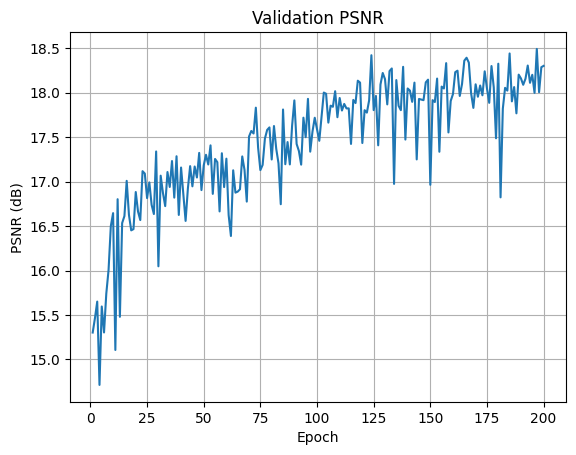

In [27]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_random_invert/validation_psnr.png', dpi=300, bbox_inches='tight')

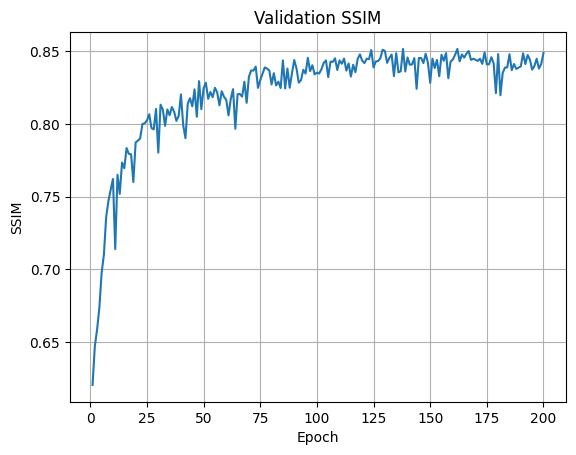

In [28]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_random_invert/validation_ssim.png', dpi=300, bbox_inches='tight')

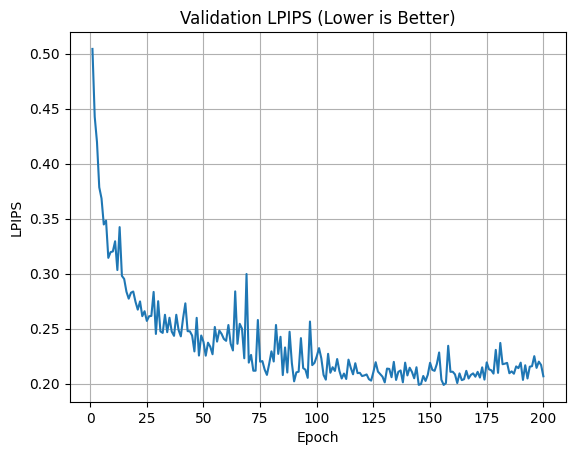

In [29]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)
plt.savefig('RRDB_CHECKPOINTS_random_invert/validation_lpips.png', dpi=300, bbox_inches='tight')

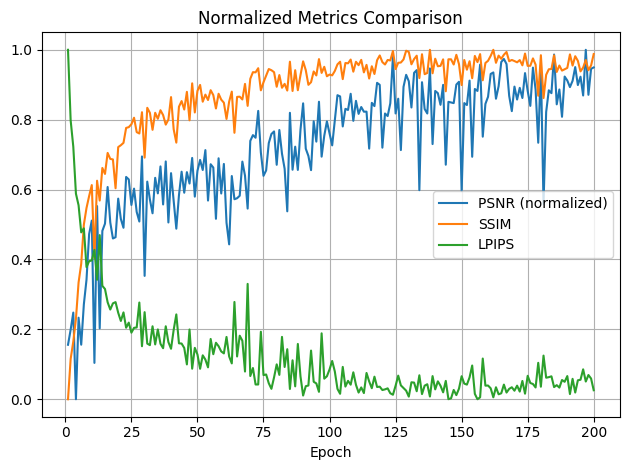

In [30]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend(loc='right')
plt.grid(True)

plt.tight_layout()
plt.savefig('RRDB_CHECKPOINTS_random_invert/training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()